# Plug and Play

#### Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from torchvision.transforms import GaussianBlur


import torch
from torchmetrics.image import TotalVariation
from torchmetrics.functional.image import image_gradients

#from metricas import *
from forward_autograd.degradacion import *
from drunet.network_unet import UNetRes as net

#### Data-loading

In [8]:
#x_real = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_real = np.zeros((256,256))
x_real = torch.tensor(x_real)

In [9]:
def T_linea(dim_filas, dim_columnas, x):
    return forward(dim_filas, dim_columnas, x)

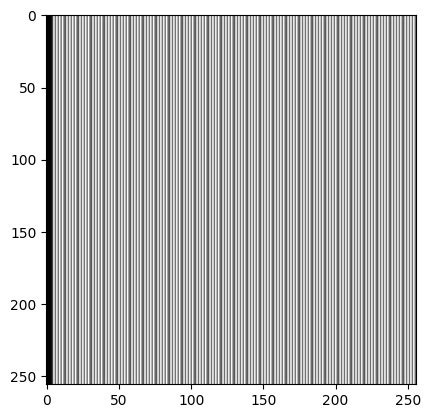

In [11]:
imagen = torch.zeros((x_real.shape[0],x_real.shape[1]),dtype=torch.complex64)
for i in range(x_real.shape[0]):
    imagen[i,:] = T_linea(x_real.shape[0], x_real.shape[1], x_real[i,:])
img_sim = np.abs(imagen.detach().numpy())
plt.figure()
plt.imshow(255*((img_sim - img_sim.min())/(img_sim.max()-img_sim.min())),cmap='gray')
plt.show()

In [12]:
model_path = os.path.join('./drunet/drunet_gray.pth')
model = net(in_nc=1+1, out_nc=1, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
for _, v in model.named_parameters():
    v.requires_grad = False

In [ ]:
def get_sigma(iter_num=15, modelSigma1=49.0, modelSigma2=2.55, w=1.0):
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    modelSigmaS_lin = np.linspace(modelSigma1, modelSigma2, iter_num).astype(np.float32)
    sigmas = (modelSigmaS*w+modelSigmaS_lin*(1-w))/255.
    return sigmas

In [ ]:
noise_level_model =  7.65/255.0
iter_num = 8
modelSigma1 = 49
modelSigma2 = noise_level_model * 255.0
sigma = get_sigma(iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1.0)
sigmas = torch.tensor(sigma)

In [ ]:
# convert uint (HxWxn_channels) to 4-dimensional torch tensor
def uint2tensor4(img):
    if img.ndim == 2:
        #agrega una dimension mas al array (600,800) --> (600,800,1)
        img = np.expand_dims(img, axis=2)
        #np.ascontiguousarray(img) guarda todas las entradas de la red en lugares adyacentes en memoria
        #permute cambia las dims (600, 800, 1) --> (1, 600, 800)
        #float() pasa las entradas del array a tipo float
        #div(255.) divide todos los elementos entre 255
        #unsqueeze agrega una dimension en la dim especificada (1, 600, 800) --> (1, 1, 600, 800)
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().div(255.).unsqueeze(0)

#### Creation of the model

In [ ]:
def minimizeViaTorch(funcion_objetivo, x0, x_filas, x_columnas, lr=0.1, max_iter=100, eps=1e-6):

    params = x0
    params.requires_grad_()
    optimizer = torch.optim.Adam([params], lr=lr)

    diff = torch.inf

    k = 0

    while (k < max_iter) and (diff > eps):

        print(f"k: {k}, diff: {diff}", end="\r", flush=True)

        params_ant = params.detach().clone()

        optimizer.zero_grad()
        loss = funcion_objetivo(x_filas, x_columnas, params)
        print('loss = {}'.format(loss))
        loss.backward(retain_graph=True)
        optimizer.step()

        params_sig = params.detach().clone()

        diff = torch.norm(params_sig - params_ant)

        k += 1

    print("\n\n")

    return params.detach().clone()

#### Run model

In [ ]:
### INICIALIZO VARIABLES ###

mu = 0.0001

diff_x = torch.inf

cant_filas = x_real.shape[0]

###SE VA TRABAJAR CON SOLO UNA LINEA. SE ELIJE LA LINEA 200. SE APILA LA DEGRADACION DE ESA LINEA VARIAS VECES PARA FORMAR IMAGEN y_img###
y_img = x_real.clone()
cant_filas = x_real.shape[0]
fila_200 = T_linea(x_real.shape[0], x_real.shape[1], x_real[200,:])
for i in range(cant_filas):
    y_img[i,:] = fila_200
#x y z se inicializan iguales a y_img
x = uint2tensor4(torch.randint(0, 1, size=(x_real.shape[0],x_real.shape[1])).float())
z = uint2tensor4(y_img.clone().detach().numpy())
x_sig_img = x.clone()
x_sig_uint = y_img.clone()
y = fila_200

### TERMINO DE INICIALIZAR VARIABLES ###

x_filas = x.shape[2]
x_columnas = x.shape[3]

for iter in range(iter_num):
    print(f"Iteración: {iter}/{iter_num}", end="\r", flush=True)
    print(f"\ndiff_x: {diff_x}") 
    fila_i_esima = x[0,0,200,:].clone().detach().requires_grad_(True)
    def actualizacion_fila_x(x_filas, x_columnas, x_param_linea):
        print('reg = {}'.format(mu*sigmas[iter]*torch.norm(x_param_linea - z[0,0,200,:])**2))
        return torch.norm(y - T_linea(x_filas, x_columnas, x_param_linea))**2 + mu*sigmas[iter]*torch.norm(x_param_linea - z[0,0,200,:])**2
    # Actualizacion de x
    x_opt = minimizeViaTorch(actualizacion_fila_x, x0=fila_i_esima, x_filas = x_filas, x_columnas = x_columnas, lr=1e-3, max_iter=20, eps=1e-5)

    for i in range(cant_filas):
        x_sig_uint[i,:] = x_opt

#PARA QUE CORRA MAS RAPIDO CORRERLO LO DE ARRIBA CON UNA LINEA Y DESPUES DUPLICAR HASTA FORMAR UNA IMAGEN

    x_sig_img = uint2tensor4(x_sig_uint.detach().numpy())

    # Actualizacion de z (.predict de red)
    x_sig_img = torch.cat((x_sig_img, sigmas[iter].float().repeat(1, 1, x_sig_img.shape[2], x_sig_img.shape[3])), dim=1)
    z_sig_img = model(x_sig_img)

    # Recalculo diferencia entre actualizaciones
    diff_x = torch.norm(x_sig_img - x)

    # Asigno la actualizacion
    x = x_sig_img.clone()
    z = z_sig_img.clone()

print("\nFin!")

Iteracion: 0/8
diff_x: inf
reg = 1.923619720400893e-06
loss = 1.923619720400893e-06
reg = 1.121579543905682e-0654895
loss = 1.3247524748294381e-06
reg = 5.992189926473657e-0700046
loss = 1.1352228739269776e-06
reg = 3.452170460604975e-072918
loss = 1.2071960782122915e-06
reg = 2.5723713292791217e-078812
loss = 1.3196157624406624e-06
reg = 2.530142069190333e-0734238
loss = 1.3482142549037235e-06
reg = 2.9639903686984326e-0767075
loss = 1.3029357432969846e-06
reg = 3.7061508351143857e-078769
loss = 1.2220750704727834e-06
reg = 4.6983609536255244e-076695
loss = 1.1489025837363442e-06
reg = 5.887191605324915e-0767535
loss = 1.108784090320114e-06
reg = 7.147978635657637e-07646717
loss = 1.111571691581048e-06
reg = 8.27792803193006e-071224194
loss = 1.142499627349025e-06
reg = 9.066394568435499e-0786013
loss = 1.1757698530345806e-06
reg = 9.368719702251838e-07463874
loss = 1.1921006262127776e-06
reg = 9.166135441773804e-072588568
loss = 1.1727842093023355e-06
reg = 8.545899845557869e-0784586

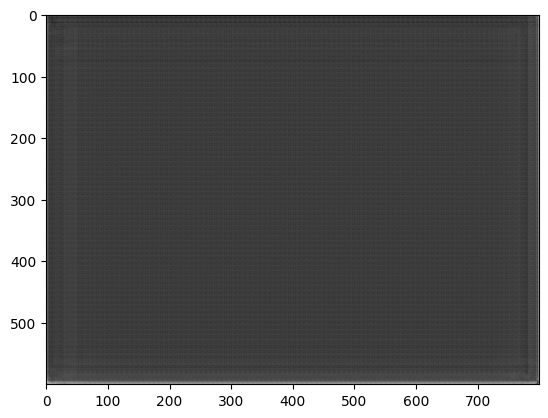

In [ ]:
plt.figure()
plt.imshow(z[0,0,:,:],cmap='gray')
plt.show()